In [1]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Load data

In [2]:
with open('../Subway base network/graph_stName_as_node.pkl', 'rb') as f:
    G_stName = pickle.load(f)
with open('../Subway base network/graph_stNo_as_node.pkl', 'rb') as f:
    G_stNo = pickle.load(f)
with open('../Subway base network/graph_stNo_as_node_invWeight.pkl', 'rb') as f:
    G_stNo_invWeight = pickle.load(f)


## About graphs
> G_stName
- Node is set to station name.
- Preserves the original subway network structure
- 역과 역 간 연결 상태를 보여줌. 즉, 두 역 사이를 지나는 노선이 여러 개더라도 하나의 edge로 인식 (nxgraph의 설정 상 어쩔 수 없음)
  
  
> G_stNo
- Node is set to station number.
- Convenient to calculate min distance within nodes. 
- 하나의 역이더라도, n개의 노선이 지난다면 n개의 노드로 구별됨. 동일 역 다른 노선(e.g. 4호선 사당역과 2호선 사당역)의 노드 사이에도 edge가 부여되며, 이 edge의 weight는 '환승 시간'에 해당됨.

## Degree analysis

In [3]:
# number of nodes

N_stName = len(list(G_stName.nodes))
print('Total nodes:', N_stName)

Total nodes: 598


Mean degree: 2.274247491638796


Text(0.5, 1.0, 'Degree distribution of the subway network of Seoul')

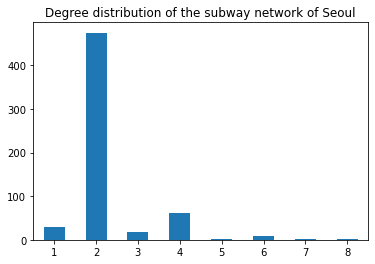

In [4]:
# degree

# given graph is directional graph; two edges with different directions exist between every two nodes
degrees = dict(G_stName.degree)
degrees_values = degrees.values()
degrees_values_undirected = [x//2 for x in degrees_values]

# average
MEAN_DEGREE = sum(degrees_values_undirected) / len(degrees_values_undirected)
print('Mean degree:', MEAN_DEGREE)

# plot
series_to_plot = pd.Series(degrees_values_undirected).value_counts().sort_index()
ax = series_to_plot.plot.bar(rot=0)
ax.set_title('Degree distribution of the subway network of Seoul')

# TMI
# Degree 8: 공덕역 (degree centrality)
# Degree 7: 왕십리역

## Calculate network distance & physical time

In [5]:
from networkx.algorithms.shortest_paths.generic import shortest_path_length

# shortest path (network distance)
network_distances = dict(shortest_path_length(G_stNo)) # usage: network_distances[source_node][target_node]

# shortest path (physical time)
physical_times = dict(shortest_path_length(G_stNo, weight='weight')) 

# number of nodes
N_stNo = len(list(G_stNo.nodes))

## Centrality analysis

In [6]:
# custom function

def find_max_key(dict):
    '''find 'all' keys whose value is max.'''

    value = max(dict.values())
    keys = []
    for key in dict:
        if dict[key] == value:
            keys.append(key)
    return keys

def find_min_key(dict):
    '''find 'all' keys whose value is min.'''

    value = min(dict.values())
    keys = []
    for key in dict:
        if dict[key] == value:
            keys.append(key)
    return keys

### Closeness centrality
- Closeness centrality
- Closeness centrality based on eccentricity
- Radius and diameter

In [7]:
# closeness centrality
def get_closeness_centralities(distance_dict):
    closeness_centralities = {}

    for x in list(G_stNo.nodes):
        value = (N_stNo - 1) / sum(distance_dict[x].values()) # formula of closeness centrality
        closeness_centralities[x] = value

    return closeness_centralities   


closeness_centralities_ntwk = get_closeness_centralities(network_distances)
closeness_centralities_phy = get_closeness_centralities(physical_times)

print('By network distance:', find_max_key(closeness_centralities_ntwk))
print('By physical time:', find_max_key(closeness_centralities_phy))
# 'K111'은 이촌역(경의중앙선) 
# '426'은 서울역(4호선)

By network distance: ['K111']
By physical time: ['426']


In [8]:
# closeness centrality based on eccentricity (radius and diameter)

# eccentricity of node i := greatest distance between i and another nodes    
def get_eccentricities(distance_dict):

    # eccentricities by each node
    eccentricities = {node:0 for node in list(G_stNo.nodes)} 

    for x in list(G_stNo.nodes):
        max_dist = max(distance_dict[x].values()) # maxiumum distance when source node is x
        eccentricities[x] = max_dist

    return eccentricities


eccentricities_ntwk = get_eccentricities(network_distances)
eccentricities_phy = get_eccentricities(physical_times)

print('By network distance:', find_min_key(eccentricities_ntwk))
print('By physical time:', find_min_key(eccentricities_phy))

# '136'은 노량진(1호선), '431'은 동작(4호선), '432'는 총신대입구(이수)(4호선), '434'는 남태령(4호선)
# '432'는 총신대입구(이수)(4호선)

By network distance: ['136', '431', '432', '434']
By physical time: ['432']


In [9]:
# radius and diameter

# radius := min(eccentricity)
# diameter := max(eccentricity)
print('Radius by network distance:', min(eccentricities_ntwk.values()))
print('Diameter by network distance:',max(eccentricities_ntwk.values()))
print('Radius by physical time:',min(eccentricities_phy.values()))
print('Diameter by physical time:',max(eccentricities_phy.values()))

Radius by network distance: 39
Diameter by network distance: 75
Radius by physical time: 121
Diameter by physical time: 242


### Betweenness centrality

In [10]:
# betweenness centrality
from networkx.algorithms.centrality import betweenness_centrality

betweenness_centrality_ntwk = betweenness_centrality(G_stNo)
betweenness_centrality_phy = betweenness_centrality(G_stNo, weight = 'weight')

print('By network distance:',find_max_key(betweenness_centrality_ntwk))
print('By physical time:',find_max_key(betweenness_centrality_phy))
# 'K116'은 왕십리(경의중앙선)
# '141'은 구로(1호선)

By network distance: ['K116']
By physical time: ['141']


### Eigenvector centrality

In [11]:
### 이제부터 G_stNo 대신 G_stNo_invWeight 사용!!
G_stNo = G_stNo_invWeight

In [12]:
# eigenvector centrality
from networkx.algorithms.centrality import eigenvector_centrality

eigenvector_centrality_ntwk = eigenvector_centrality(G_stNo, max_iter=1000)
eigenvector_centrality_phy = eigenvector_centrality(G_stNo, weight = 'weight', max_iter=1000)

print('By network distance:',find_max_key(eigenvector_centrality_ntwk))
print('By physical time:',find_max_key(eigenvector_centrality_phy))
# 'A02'은 공덕(공항철도)
# 'A05'은 김포공항(공항철도)

By network distance: ['A02']
By physical time: ['U121']


In [14]:
eigenvector_centrality_phy_sorted = sorted(eigenvector_centrality_phy.items(), key=lambda item: item[1])
eigenvector_centrality_phy_sorted.reverse()

In [15]:
eigenvector_centrality_phy_sorted[:10]

[('U121', 0.5760737726919646),
 ('U120', 0.5750674916721313),
 ('U122', 0.38572771334533795),
 ('U119', 0.3830431230106425),
 ('U123', 0.13451175067370344),
 ('U118', 0.1275694126874204),
 ('U124', 0.06295872645516137),
 ('U117', 0.04248598741633585),
 ('U125', 0.03774880524330533),
 ('U115', 0.014149703596175232)]

In [16]:
eigenvector_centrality_ntwk_sorted = sorted(eigenvector_centrality_ntwk.items(), key=lambda item: item[1])
eigenvector_centrality_ntwk_sorted.reverse()
eigenvector_centrality_ntwk_sorted[:10]

[('A02', 0.40903761254301557),
 ('K312', 0.3589080332232166),
 ('626', 0.3489641608384828),
 ('529', 0.3486645439320667),
 ('A01', 0.29651527241222075),
 ('133', 0.24397229881484994),
 ('426', 0.24048463023650396),
 ('P313', 0.22747397667535665),
 ('A03', 0.1933047395068824),
 ('K314', 0.1313943088702893)]

In [17]:
# Katz centrality
from networkx.algorithms.centrality import katz_centrality

katz_centrality_ntwk = katz_centrality(G_stNo)
#katz_centrality_phy = katz_centrality(G_stNo, weight='weight', max_iter=100000)

print('By network distance:',find_max_key(katz_centrality_ntwk))
#print('By physical time:',find_max_key(katz_centrality_phy))

# 'A02'은 공덕(공항철도)

By network distance: ['A02']


In [18]:
# PageRank
from networkx.algorithms.link_analysis.pagerank_alg import pagerank

pagerank_ntwk = pagerank(G_stNo)
pagerank_phy = pagerank(G_stNo, weight='weight')

print('By network distance:',find_max_key(pagerank_ntwk))
print('By physical time:',find_max_key(pagerank_phy))
# 'A05'은 김포공항(공항철도)

By network distance: ['618']
By physical time: ['618']
